## Linestrings buffer

Nesse notebook são construídas as linestrings dos ônibus e aplicado um buffer.

In [1]:
import geopandas as gpd
from shapely.geometry import LineString
from utils.load_csv import load_csv
from utils.save_shp import save_shp

In [2]:
df_onibus = load_csv('calculo-distancia-percorrida_2025-10-19_silver_corrigido.csv')

In [3]:
BUFFER = 10

In [4]:
gdf_onibus = gpd.GeoDataFrame(df_onibus, geometry = gpd.points_from_xy(df_onibus.x, df_onibus.y), crs = 'EPSG:4326')

gdf_onibus = gdf_onibus.to_crs('EPSG:31983')

In [5]:
gdf_onibus = gdf_onibus.sort_values(['codigo_onibus', 'hora_gps']).reset_index(drop = True)

counts = gdf_onibus.codigo_onibus.value_counts()

remover = counts[counts < 2].index

gdf_onibus = gdf_onibus[~gdf_onibus.codigo_onibus.isin(remover)]

In [6]:
linhas = []

for codigo, grupo in gdf_onibus.groupby('codigo_onibus'):

    pts = grupo.geometry.tolist()
    horas = grupo.hora_gps.tolist()

    for i in range(len(pts) - 1):
        if pts[i] != pts[i+1]:
            linhas.append({
                'codigo_onibus': codigo,
                'hora_inicio': horas[i],
                'hora_fim': horas[i+1],
                'geometry': LineString([pts[i], pts[i+1]])
            })

gdf_onibus = gpd.GeoDataFrame(linhas, geometry = 'geometry', crs = 'EPSG:31983')

In [7]:
gdf_onibus['buffer'] = gdf_onibus.geometry.buffer(BUFFER)

In [8]:
gdf_onibus.head()

,codigo_onibus,hora_inicio,hora_fim,geometry,buffer
0,3117,2025-10-19 00:03:41-03:00,2025-10-19 00:06:41-03:00,"LINESTRING (343000.574 7391331.953, 343564.721...","POLYGON ((343572.052 7390730.514, 343572.684 7..."
1,3117,2025-10-19 00:06:41-03:00,2025-10-19 00:09:41-03:00,"LINESTRING (343564.721 7390723.714, 344148.795...","POLYGON ((344157.012 7389887.302, 344157.531 7..."
2,3117,2025-10-19 00:09:41-03:00,2025-10-19 00:17:09-03:00,"LINESTRING (344148.795 7389881.603, 343755.093...","POLYGON ((343764.832 7388190.704, 343764.562 7..."
3,3117,2025-10-19 00:17:09-03:00,2025-10-19 00:18:42-03:00,"LINESTRING (343755.093 7388192.975, 343935.863...","POLYGON ((343941.324 7388083.512, 343942.119 7..."
4,3117,2025-10-19 00:18:42-03:00,2025-10-19 06:57:33-03:00,"LINESTRING (343935.863 7388075.135, 352409.518...","POLYGON ((352411.072 7386751.591, 352412.033 7..."


<Axes: >

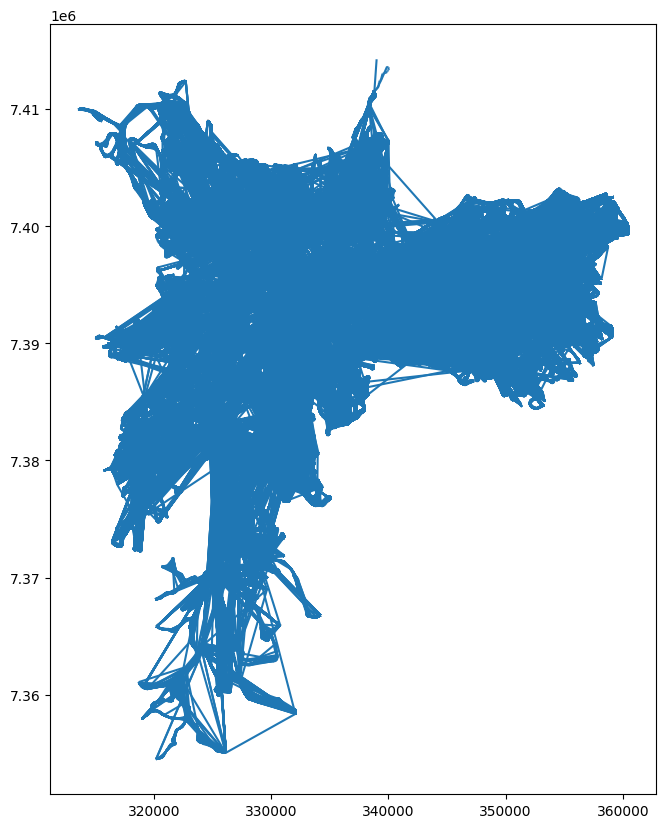

In [9]:
gdf_onibus.plot(figsize = (10, 10))

In [10]:
gdf_onibus = gdf_onibus.set_geometry('buffer')

gdf_onibus = gdf_onibus.drop(columns = ['geometry'])

In [11]:
save_shp(gdf_onibus, 'gdf_onibus.shp')

c:\Users\caiod\projetos\onibus_eletricos_saude\utils\save_shp.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(file_path)
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'codigo_onibus' to 'codigo_oni'
  ogr_write(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'hora_inicio' to 'hora_inici'
  ogr_write(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: 2GB file size limit reached for data\gdf_onibus.shp. Going on, but might cause compatibility issues with third party software
  ogr_write(


Shapefile salvo em data\gdf_onibus.shp
